# Far-field projection limitations with non-confined fields

Far-field projections are a great way to reduce computational cost by using the equivalence principle to calculate far fields based on near-field data. The general workflow is demonstrated in [this](https://www.flexcompute.com/tidy3d/examples/notebooks/FieldProjections/) notebook.

However, as discussed in our [technical article](https://www.flexcompute.com/tidy3d/learn-center/technical-article/far-field-projection/), there are two main limitations of the far-field projection: the near fields must either be calculated on a closed surface with a uniform index, or the fields must decay at the borders of a 2D monitor.

This can be a challenging limitation for scatterers placed on a substrate, where a closed monitor will cross regions with different indices, and the fields are likely not decaying at the boundaries.

In this notebook, we will explore the limitations of this scenario and discuss caveats and workarounds.

In [1]:
import numpy as np
import pandas as pd
import tidy3d as td
from matplotlib import pyplot as plt
from tidy3d import web

## Simulation Setup

We will analyze a simple case of a silicon box scatterer on a silicon oxide substrate.

First, we will create a function to build the base simulation for our analysis, using the simulation plane size as a parameter. To compute the far-field projection, we will place several 2D monitors of the [FieldProjectionCartesianMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) class above the scatterer, using different `window_size` values. This parameter defines the size of the transition region of the windowing function, ensuring that the recorded near fields decay to zero near the monitor edges.

We will also add one 3D [FieldProjectionCartesianMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) surrounding the scatterer, with the z-plane aligned to the substrate interface so it can be excluded from the far-field projection calculation.

For reference, we will add a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) 10 µm away from the scatterer, and another one at the same position as the 2D far-field projection monitors.

Since the field projection distance is small, the `far_field_approx` argument is set to `False`.

In [2]:
freq0 = td.C_0 / 1.55
fwidth = 0.1 * freq0

In [3]:
def getSim(size):
    source = td.PlaneWave(
        name="source",
        center=[0, 0, -0.5],
        size=[1000, 1000, 0],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
    )

    field_monitor = td.FieldMonitor(
        center=[0, 0, 10],
        size=[size, size, 0],
        name="field_monitor",
        freqs=[freq0],
    )

    near_field_monitor = td.FieldMonitor(
        center=(0.0, 0.0, 2.1),
        size=(size, size, 0),
        name="near_field_monitor",
        freqs=[freq0],
        colocate=False,
    )

    far_field_monitors_2d = []
    for window_size in [0, 0.2, 0.4, 0.6, 0.8]:
        far_field_monitor_2d = td.FieldProjectionCartesianMonitor(
            center=(0.0, 0.0, 2.1),
            size=(size, size, 0),
            name=f"far_field_monitor_{window_size:.2f}",
            freqs=[freq0],
            normal_dir="+",
            far_field_approx=False,
            proj_axis=2,
            proj_distance=10,
            x=np.linspace(-field_monitor.size[0] / 2, field_monitor.size[0] / 2, 101),
            y=np.linspace(-field_monitor.size[1] / 2, field_monitor.size[1] / 2, 101),
            window_size=(window_size, window_size),
            custom_origin=(0, 0, 0),
        )
        far_field_monitors_2d.append(far_field_monitor_2d)

    far_field_monitor_3d = td.FieldProjectionCartesianMonitor(
        center=(0, 0, 1.5),
        size=(0.9 * size, 0.9 * size, 2.9),
        name="far_field_monitor_3D",
        freqs=[freq0],
        exclude_surfaces=["z-"],
        far_field_approx=False,
        proj_axis=2,
        proj_distance=10,
        x=np.linspace(-field_monitor.size[0] / 2, field_monitor.size[0] / 2, 101),
        y=np.linspace(-field_monitor.size[1] / 2, field_monitor.size[1] / 2, 101),
        custom_origin=(0, 0, 0),
    )

    SiO2 = td.Medium(
        name="medium_1",
        permittivity=1.45**2,
    )
    substrate = td.Structure(
        geometry=td.Box(center=[0, 0, -500], size=[2000, 2000, 1000]), name="substrate", medium=SiO2
    )

    Si = td.Medium(
        name="Si",
        permittivity=3.5**2,
    )
    scatterer = td.Structure(
        geometry=td.Box(center=[0, 0, 0.5], size=[1, 1, 1]),
        name="scatterer",
        background_medium=td.MultiPhysicsMedium(),
        medium=Si,
    )

    sim = td.Simulation(
        center=[0, 0, 5],
        size=[size, size, 12],
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=25),
        run_time=2e-12,
        sources=[source],
        monitors=[field_monitor, near_field_monitor, far_field_monitor_3d] + far_field_monitors_2d,
        structures=[substrate, scatterer],
    )

    return sim


sim_base = getSim(10)

Now we can take a look at the setup:

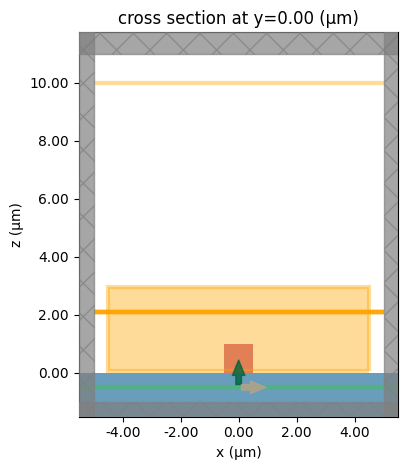

In [4]:
sim_base.plot(y=0)
plt.show()

In [5]:
sim_base.plot_3d()

In [6]:
sim_data = web.run(sim_base, task_name="far_field_1", folder_name="FFP")

14:23:46 -03 Created task 'far_field_1' with resource_id                        
             'fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=865723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=759396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\taskId]8;;\]8;id=865723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\=]8;;\]8;id=321982;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\fdve]8;;\]8;id=865723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\-b8b6a55c-f86]8;;\
             ]8;id=865723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\e-4561-ad97-7804b80112e2']8;;\.

             Task folder: ]8;id=746902;https://tidy3d.simulation.cloud/folders/folder-96f7e105-3c75-4d04-a285-5ce84e45ffa7\'FFP']8;;\.

Output()

14:23:50 -03 Estimated FlexCredit cost: 0.432. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

14:23:52 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

14:24:00 -03 status = preprocess

14:24:05 -03 starting up solver

14:24:06 -03 running solver

Output()

14:24:37 -03 early shutoff detected at 32%, exiting.

             status = postprocess

Output()

14:24:39 -03 status = success

14:24:41 -03 View simulation result at                                          
             ]8;id=96613;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=98146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\taskId]8;;\]8;id=96613;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\=]8;;\]8;id=19638;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\fdve]8;;\]8;id=96613;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\-b8b6a55c-f86]8;;\
             ]8;id=96613;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8b6a55c-f86e-4561-ad97-7804b80112e2\e-4561-ad97-7804b80112e2']8;;\.

Output()

14:28:18 -03 loading simulation from simulation_data.hdf5

Now we can visualize side by side the field projection using the 2D monitor, with the `window_size` argument set to `(0, 0)`, i.e., using the raw near-field data without filtering, and the far-field projection from the 3D monitor.

For reference, we will also plot the field monitor with the expected field profile, as well as the field monitor showing the raw near fields.

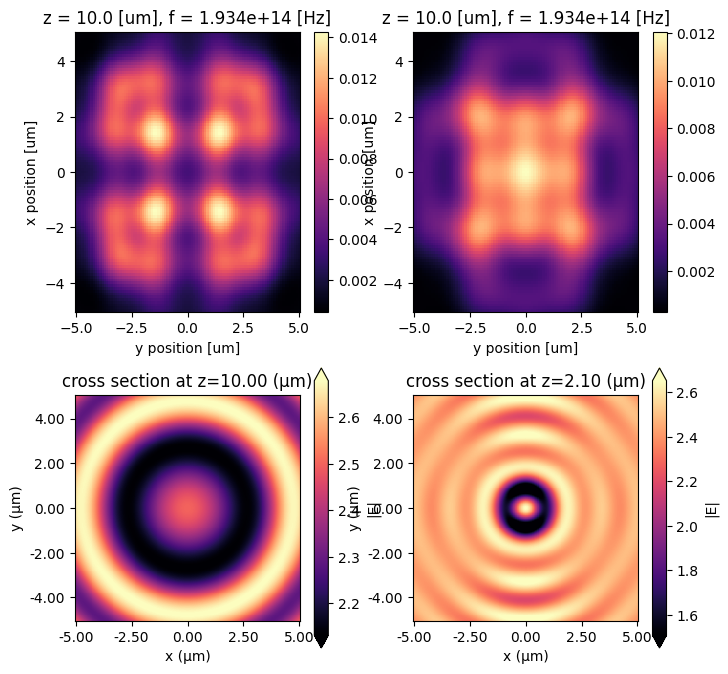

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

sim_data["far_field_monitor_0.00"].power.plot(cmap="magma", ax=ax[0][0])
sim_data["far_field_monitor_3D"].power.plot(cmap="magma", ax=ax[0][1])
sim_data.plot_field("field_monitor", "E", "abs", ax=ax[1][0])
sim_data.plot_field("near_field_monitor", "E", "abs", ax=ax[1][1])

plt.show()

As we can see, the near fields do not decay at the boundaries, and consequently, the field projections do not capture the correct field profile.

Next, we can visualize the far-field projection for different values of `window_size`.

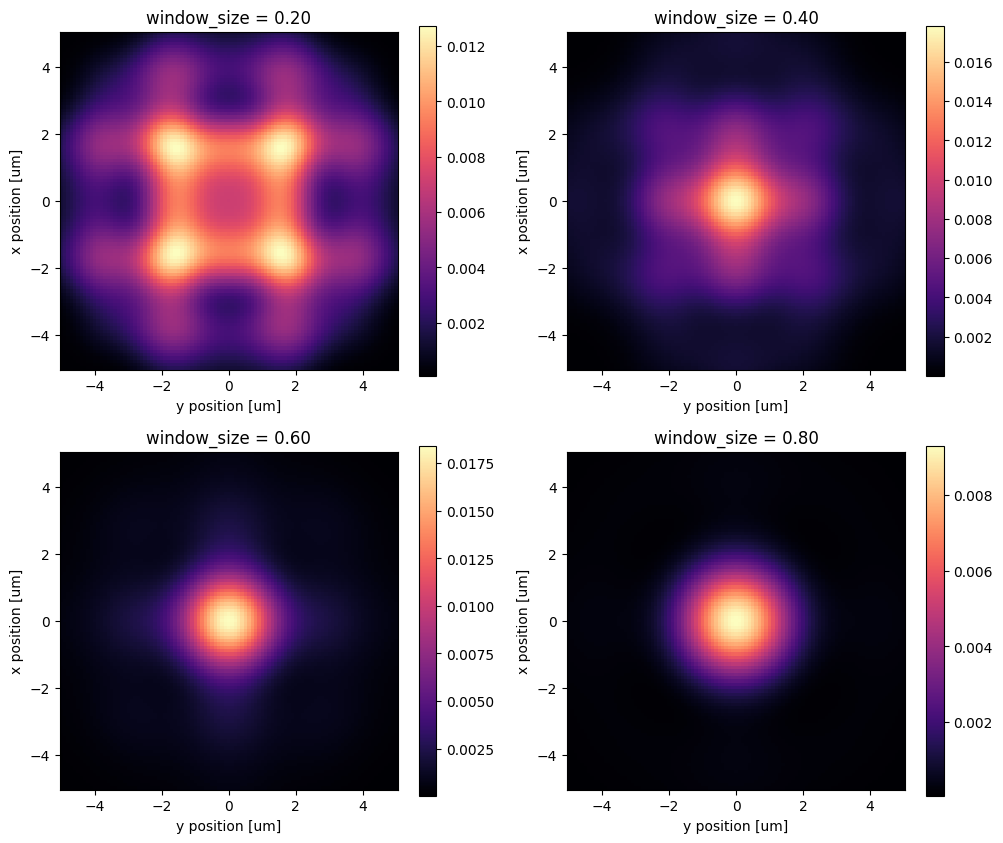

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

sim_data["far_field_monitor_0.20"].power.plot(cmap="magma", ax=ax[0][0])
sim_data["far_field_monitor_0.40"].power.plot(cmap="magma", ax=ax[0][1])
sim_data["far_field_monitor_0.60"].power.plot(cmap="magma", ax=ax[1][0])
sim_data["far_field_monitor_0.80"].power.plot(cmap="magma", ax=ax[1][1])

ax[0][0].set_title("window_size = 0.20")
ax[0][1].set_title("window_size = 0.40")
ax[1][0].set_title("window_size = 0.60")
ax[1][1].set_title("window_size = 0.80")

for axes in ax.flatten():
    axes.set_aspect("equal")

plt.show()

## Varying the Simulation Plane Size

Now, we will perform the same analysis, but increasing the simulation plane size.

In [9]:
sims = {}
for size in [20, 30, 40, 50]:
    sims[size] = getSim(size)

batch = web.Batch(simulations=sims, folder_name="TestesFFPSize")

batch_data = batch.run(path_dir="FFP_Size")

Output()

14:28:25 -03 Started working on Batch containing 4 tasks.

14:28:33 -03 Maximum FlexCredit cost: 15.807 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:31:54 -03 Batch complete.

Output()

As we can see, for larger plane sizes, it is possible to obtain a correct far-field projection. For higher values of the `window_size` argument, the projection becomes closer to the true fields, at the cost of a smaller region of interest.

Therefore, in cases where a 3D field projection monitor is not feasible, and the fields do not sufficiently decay at the edges of a 2D projection monitor, a compromise between the simulation plane size and the usable region of interest is necessary.

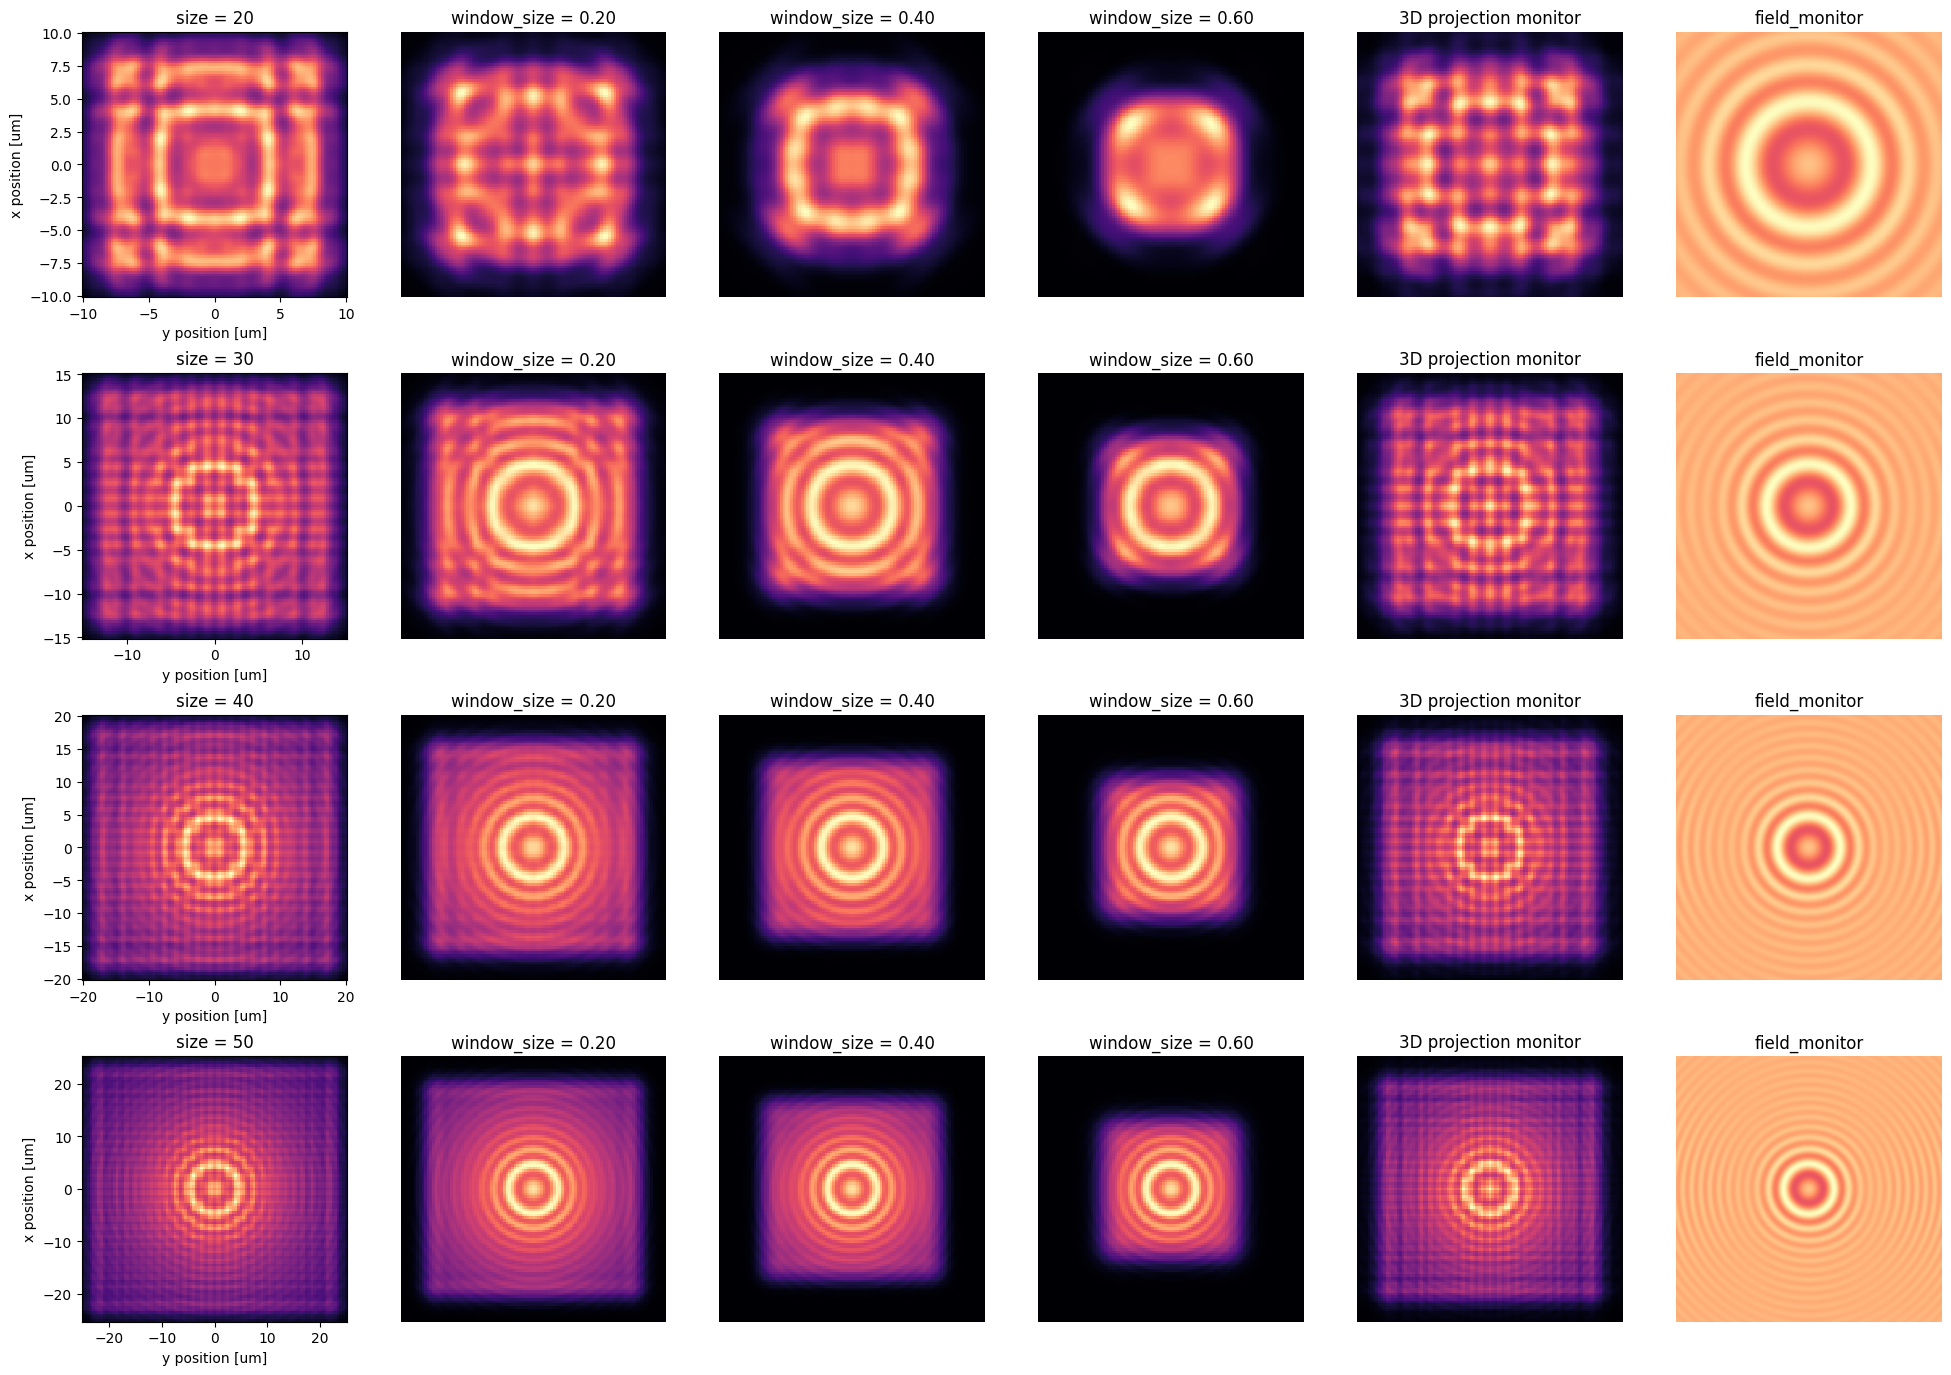

In [10]:
fig, Ax = plt.subplots(4, 6, figsize=(24, 17))
import matplotlib as mpl

for i, size in enumerate(sims.keys()):
    sim_data2 = batch_data[str(size)]

    sim_data2["far_field_monitor_0.00"].power.plot(
        cmap="magma", ax=Ax[i][0], add_colorbar=False, vmin=0
    )
    sim_data2["far_field_monitor_0.20"].power.plot(
        cmap="magma", ax=Ax[i][1], add_colorbar=False, vmin=0
    )
    sim_data2["far_field_monitor_0.40"].power.plot(
        cmap="magma", ax=Ax[i][2], add_colorbar=False, vmin=0
    )
    sim_data2["far_field_monitor_0.60"].power.plot(
        cmap="magma", ax=Ax[i][3], add_colorbar=False, vmin=0
    )

    sim_data2["far_field_monitor_3D"].power.plot(
        cmap="magma", ax=Ax[i][4], add_colorbar=False, vmin=0
    )

    E = (
        np.abs(sim_data2["field_monitor"].Ex) ** 2
        + np.abs(sim_data2["field_monitor"].Ey) ** 2
        + np.abs(sim_data2["field_monitor"].Ez) ** 2
    )
    E.plot(cmap="magma", ax=Ax[i][5], add_colorbar=False, vmin=0)

    Ax[i][0].set_title(f"size = {size}")
    Ax[i][1].set_title("window_size = 0.20")
    Ax[i][2].set_title("window_size = 0.40")
    Ax[i][3].set_title("window_size = 0.60")
    Ax[i][4].set_title("3D projection monitor")
    Ax[i][5].set_title("field_monitor")

    Ax[i][1].axis("off")
    Ax[i][2].axis("off")
    Ax[i][3].axis("off")
    Ax[i][4].axis("off")
    Ax[i][5].axis("off")
for axes in Ax.flatten():
    axes.set_aspect("equal")


plt.show()